Start by loading in al the libarys.

In [2]:
%matplotlib notebook

import matplotlib
matplotlib.use('TKAgg')

In [3]:

from Basis import *

import casadi as ca
import casadi.tools as ca_tools

import numpy as np

import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

import random

Generating the points

 

<IPython.core.display.Javascript object>


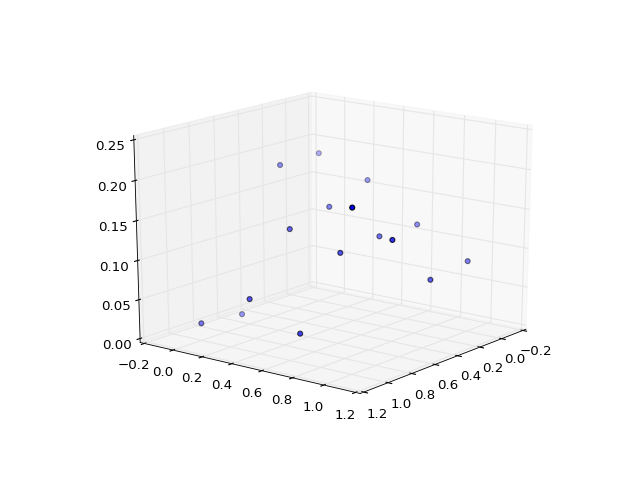

In [4]:
n = 4

x = [1.0*i/(n-1) for i in range(n) ]
y = [1.0*i/(n-1) for i in range(n) ]

x_list = n*x
y_list = sorted(n*y)

random.seed(2)
z_list = [0.2*random.random() for _ in x_list]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_list,y_list,z_list,'ko')
plt.show()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      370
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       17
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

<IPython.core.display.Javascript object>


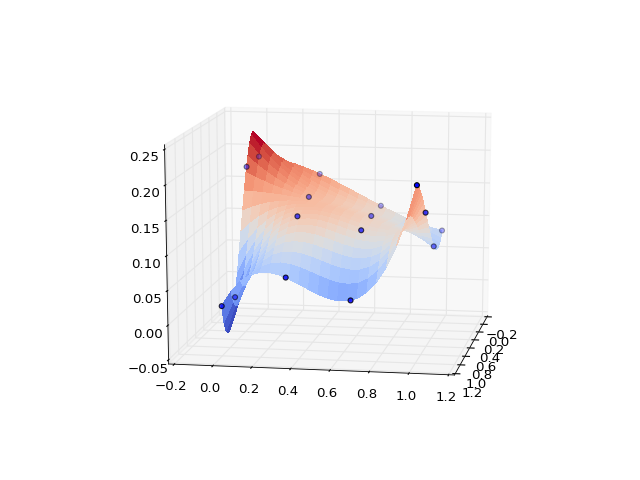

In [6]:
degree = 3
#m = SubBSplineBasis([0,1],degree,3)
m = SubMonomialBasis(degree)
b = Basis([m,m])


V = ca_tools.struct_symSX([
    ca_tools.entry('a',shape = [m.getLenght(),m.getLenght()]),
    ca_tools.entry('bound')
])

a_ = V["a"]
bound = V["bound"]

a = STensor(a_, [m.getLenght(),m.getLenght(),1,1])
a = Coefficient(a)
est_function = Function(b,a)
con = []
con_lower = []
con_upper = []

for x_,y_,z_ in zip(x_list,y_list,z_list):
     con.append(est_function([x_,y_]).data() - bound)
     con_lower.append(-ca.inf)
     con_upper.append(z_)
    
     con.append(est_function([x_,y_]).data() + bound)
     con_lower.append(z_)
     con_upper.append(ca.inf)
        
        
obj = bound

nlp = { 'x':V,'f':obj,'g':ca.vertcat(*con) }


solver = ca.nlpsol("solver","ipopt", nlp)
r = solver(lbg = con_lower, ubg = con_upper)
sol = V(r['x'])

a = ca.DM(sol['a'].full())
a = DTensor(a, [m.getLenght(),m.getLenght(),1,1])

a = Coefficient(a)
est_function = Function(b,a)



import numpy as np

n = 20

X = np.arange(0, 1.01, 1.0/n)
Y = np.arange(0, 1.01, 1.0/n)
X, Y = np.meshgrid(X, Y)

Z = X.copy()
rX = range(len(list(Z)) )
rY = range(len(list(Z[0])) )

for i in rX:
    for j in rY:
        x_ = X[i,j]
        y_ = Y[i,j] 
        Z[i,j] = est_function([x_,y_]).data()
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.scatter(x_list,y_list,z_list,'ko')
plt.show()

<IPython.core.display.Javascript object>


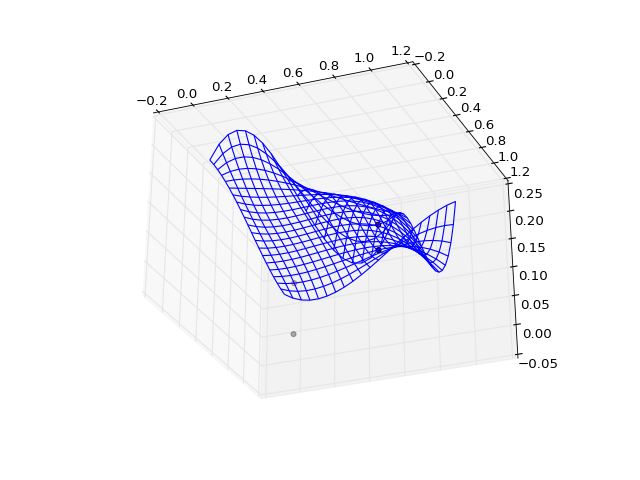

In [7]:
x_0 = 0.1
y_0 = 0.9

x_1 = 0.9
y_1 = 0.1

z_0 = est_function([x_0, y_0]).data()
z_1 = est_function([x_1, y_1]).data()

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_wireframe(X, Y, Z)

ax.scatter([x_0, x_1],[y_0, y_1],[0,0],c='k')

ax.scatter([x_0, x_1],[y_0, y_1],[z_0, z_1],c='r')

plt.show()

In [8]:
degree = 2
m_path = SubBSplineBasis([0,1],degree,6)
b_path = Basis([m_path])


V = ca_tools.struct_symSX([
    ca_tools.entry('ax',shape = [m_path.getLenght(),1]),
    ca_tools.entry('ay',shape = [m_path.getLenght(),1]),
    ca_tools.entry('t'),
    ca_tools.entry('max_path')
])

ax_ = V["ax"]
ay_ = V["ay"]
t = V["t"]
max_path = V["max_path"]

ax = STensor(ax_, [m_path.getLenght(),1,1])
ax = Coefficient(ax)
x_path = Function(b_path,ax)

ay = STensor(ay_, [m_path.getLenght(),1,1])
ay = Coefficient(ay)
y_path = Function(b_path,ay)

con = []
con_lower = []
con_upper = []


x_ = x_0
y_ = y_0 
z_ = z_0

obj = 0


n = 41 

    
for t_ in np.linspace(0.,1.,n):
    x_n = x_path([t_]).data()
    y_n = y_path([t_]).data()
    z_n = est_function([x_n,y_n]).data()
    
    con.append(max_path - z_n)
    con_lower.append(0)
    con_upper.append(ca.inf)

obj = max_path
               
con.append(x_path.getCoefficient().getData().data())
con.append(y_path.getCoefficient().getData().data())
for _ in range(m_path.getLenght()):
    con_lower.append(0)
    con_lower.append(0)
    con_upper.append(1)
    con_upper.append(1)

con.append(x_path([0]).data())
con_lower.append(x_0)
con_upper.append(x_0)
con.append(y_path([0]).data())
con_lower.append(y_0)
con_upper.append(y_0)

con.append(x_path([1]).data())
con_lower.append(x_1)
con_upper.append(x_1)
con.append(y_path([1]).data())
con_lower.append(y_1)
con_upper.append(y_1)



x0 = V(0.0)
x0["ax"] = np.linspace(x_0,x_1,m_path.getLenght())
x0["ay"] = np.linspace(y_0,y_1,m_path.getLenght())
x0["t"] = 0.5

      
con = ca.vertcat(*con)    
        


nlp = { 'x':V,'f':obj,'g':con }


solver = ca.nlpsol("solver","ipopt", nlp)
r = solver(lbg = con_lower, ubg = con_upper,x0=x0)
sol = V(r['x'])




This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:      287
Number of nonzeros in Lagrangian Hessian.............:       65

Total number of variables............................:       16
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:       55
        inequality constraints with only lower bounds:       41
   inequality constraints with lower and upper bounds:       14
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

<IPython.core.display.Javascript object>


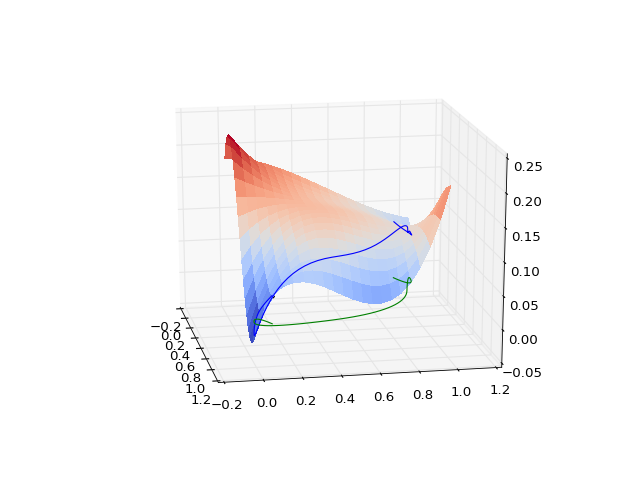

<IPython.core.display.Javascript object>


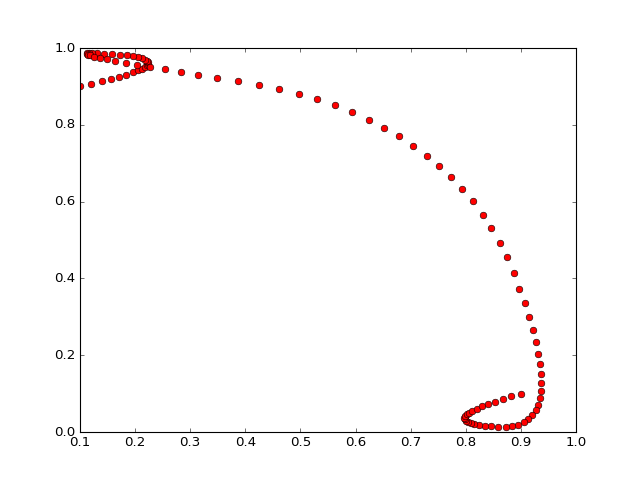

In [9]:
ax = ca.DM(sol['ax'].full())
ax = DTensor(ax, [m_path.getLenght(),1,1])
ax = Coefficient(ax)
x_path = Function(b_path,ax)

ay = ca.DM(sol['ay'].full())
ay = DTensor(ay, [m_path.getLenght(),1,1])
ay = Coefficient(ay)
y_path = Function(b_path,ay)

nt =101

time = np.linspace(0.,1.,nt)

x_p = [x_path([t_]).data().full()[0,0] for t_ in time]
y_p = [y_path([t_]).data().full()[0,0] for t_ in time]
z_p = [float(est_function([x_path([t_]).data(),y_path([t_]).data()]).data()) for t_ in time]

fig = plt.figure()
axs = fig.gca(projection='3d')
surf = axs.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm,
                       linewidth=0, antialiased=False)

axs.scatter([x_0, x_1],[y_0, y_1],[z_0, z_1],c='r')
li = axs.plot(x_p,y_p,z_p)
li = axs.plot(x_p,y_p,nt*[0])


plt.figure()
plt.plot(x_p,y_p,'ro')


plt.show()

In [ ]:
print sol['ax']
print sol['ay']

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:      287
Number of nonzeros in Lagrangian Hessian.............:       69

Total number of variables............................:       16
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:       55
        inequality constraints with only lower bounds:       41
   inequality constraints with lower and upper bounds:       14
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

<IPython.core.display.Javascript object>


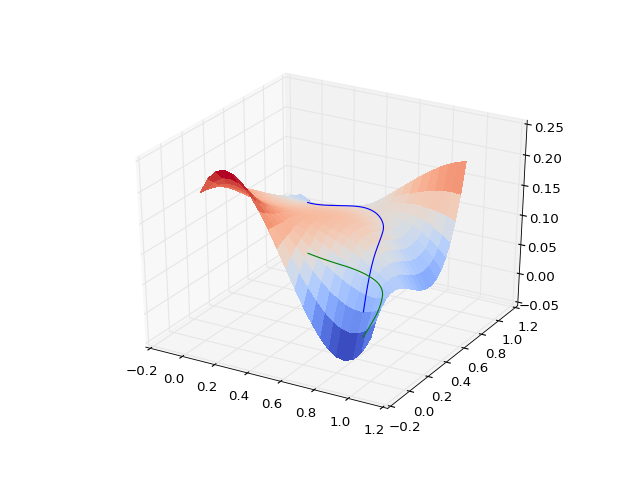

<IPython.core.display.Javascript object>


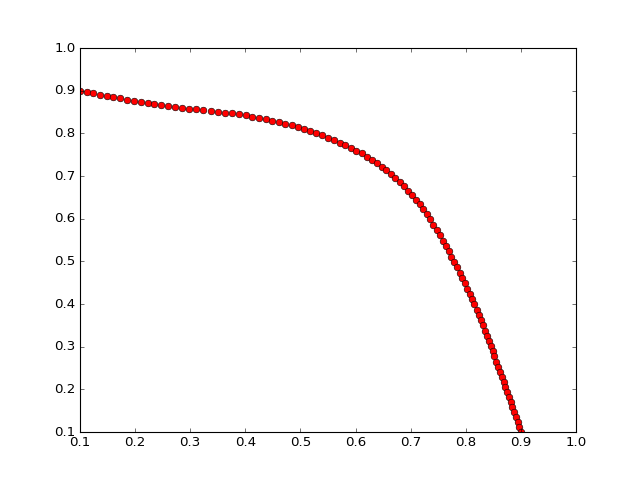

In [10]:

degree = 2
m_path = SubBSplineBasis([0,1],degree,6)
b_path = Basis([m_path])


V = ca_tools.struct_symSX([
    ca_tools.entry('ax',shape = [m_path.getLenght(),1]),
    ca_tools.entry('ay',shape = [m_path.getLenght(),1]),
    ca_tools.entry('t'),
    ca_tools.entry('max_path')
])

ax_ = V["ax"]
ay_ = V["ay"]
t = V["t"]
max_path = V["max_path"]

ax = STensor(ax_, [m_path.getLenght(),1,1])
ax = Coefficient(ax)
x_path = Function(b_path,ax)

ay = STensor(ay_, [m_path.getLenght(),1,1])
ay = Coefficient(ay)
y_path = Function(b_path,ay)

con = []
con_lower = []
con_upper = []


x_ = x_0
y_ = y_0 
z_ = z_0

obj = 0


n = 41 

for t_ in np.linspace(0.,1.,n):
    x_n = x_path([t_]).data()
    y_n = y_path([t_]).data()
    z_n = est_function([x_n,y_n]).data()
    
    con.append(max_path - z_n)
    con_lower.append(0)
    con_upper.append(ca.inf)

obj = max_path


n = 41 

for t_ in np.linspace(0.,1.,n):
    x_n = x_path([t_]).data()
    y_n = y_path([t_]).data()
    z_n = est_function([x_n,y_n]).data()
    
    obj += (x_n - x_) ** 2 + (y_n - y_) ** 2 + (z_n - z_) ** 2
    

    
    x_ = x_n
    y_ = y_n 
    z_ = z_n

               
con.append(x_path.getCoefficient().getData().data())
con.append(y_path.getCoefficient().getData().data())
for _ in range(m_path.getLenght()):
    con_lower.append(0)
    con_lower.append(0)
    con_upper.append(1)
    con_upper.append(1)

con.append(x_path([0]).data())
con_lower.append(x_0)
con_upper.append(x_0)
con.append(y_path([0]).data())
con_lower.append(y_0)
con_upper.append(y_0)

con.append(x_path([1]).data())
con_lower.append(x_1)
con_upper.append(x_1)
con.append(y_path([1]).data())
con_lower.append(y_1)
con_upper.append(y_1)



x0 = V(0.0)
x0["ax"] = np.linspace(x_0,x_1,m_path.getLenght())
x0["ay"] = np.linspace(y_0,y_1,m_path.getLenght())
x0["t"] = 0.5

      
con = ca.vertcat(*con)    
        


nlp = { 'x':V,'f':obj,'g':con }


solver = ca.nlpsol("solver","ipopt", nlp)
r = solver(lbg = con_lower, ubg = con_upper,x0=x0)
sol = V(r['x'])





ax = ca.DM(sol['ax'].full())
ax = DTensor(ax, [m_path.getLenght(),1,1])
ax = Coefficient(ax)
x_path = Function(b_path,ax)

ay = ca.DM(sol['ay'].full())
ay = DTensor(ay, [m_path.getLenght(),1,1])
ay = Coefficient(ay)
y_path = Function(b_path,ay)

nt =101

time = np.linspace(0.,1.,nt)

x_p = [x_path([t_]).data().full()[0,0] for t_ in time]
y_p = [y_path([t_]).data().full()[0,0] for t_ in time]
z_p = [float(est_function([x_path([t_]).data(),y_path([t_]).data()]).data()) for t_ in time]

fig = plt.figure()
axs = fig.gca(projection='3d')
surf = axs.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm,
                       linewidth=0, antialiased=False)

axs.scatter([x_0, x_1],[y_0, y_1],[z_0, z_1],c='r')
li = axs.plot(x_p,y_p,z_p)
li = axs.plot(x_p,y_p,nt*[0])


plt.figure()
plt.plot(x_p,y_p,'ro')


plt.show()